In [2]:
import torch
import torch.nn.functional as F
import nbimporter
from add_negative_samples import generate_all_negatives

In [3]:
# Load the graphs
train_data = torch.load('data/undirected_train_graph.pt')
val_data   = torch.load('data/undirected_val_graph.pt')
test_data  = torch.load('data/undirected_test_graph.pt')


In [4]:
print('Undirected Training Data')
print('----------------------')
print(train_data)

print('Undirected Validation Data')
print('------------------------')
print(val_data)

print('Undirected Test Data')
print('------------------')
print(test_data)


Undirected Training Data
----------------------
HeteroData(
  lncRNA={ x=[1269, 2] },
  protein={ x=[11585, 2] },
  (lncRNA, interacts, protein)={
    edge_index=[2, 5119],
    edge_attr=[5119, 4],
  },
  (protein, interacts_rev, lncRNA)={
    edge_index=[2, 5119],
    edge_attr=[5119, 4],
  },
  (protein, interacts, protein)={
    edge_index=[2, 59544],
    edge_attr=[59544, 1],
  },
  (protein, interacts_rev, protein)={
    edge_index=[2, 59544],
    edge_attr=[59544, 1],
  }
)
Undirected Validation Data
------------------------
HeteroData(
  lncRNA={ x=[1269, 2] },
  protein={ x=[11585, 2] },
  (lncRNA, interacts, protein)={
    edge_index=[2, 640],
    edge_attr=[640, 4],
  },
  (protein, interacts_rev, lncRNA)={
    edge_index=[2, 640],
    edge_attr=[640, 4],
  },
  (protein, interacts, protein)={
    edge_index=[2, 7443],
    edge_attr=[7443, 1],
  },
  (protein, interacts_rev, protein)={
    edge_index=[2, 7443],
    edge_attr=[7443, 1],
  }
)
Undirected Test Data
-------------

In [5]:
import torch
import torch.nn as nn
from torch_geometric.nn import GENConv, Linear

class HeteroGENEncoder(nn.Module):
    def __init__(self, metadata, hidden_channels, edge_dims_dict):
        """
        metadata: Tuple of (node_types, edge_types) from data.metadata()
        hidden_channels: Output dimension for node embeddings
        edge_dims_dict: Dictionary mapping edge_type to edge_attr dim
        """
        super().__init__()

        self.node_lin = nn.ModuleDict()
        for node_type in metadata[0]:
            self.node_lin[node_type] = Linear(-1, hidden_channels)

        self.convs = nn.ModuleDict()
        for edge_type in metadata[1]:
            etype_str = '__'.join(edge_type)
            edge_dim = edge_dims_dict.get(edge_type, 0)
            self.convs[etype_str] = GENConv(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                edge_dim=edge_dim,
                aggr='softmax'  # or 'mean', 'add', etc.
            )

        self.lin_post = nn.ModuleDict()
        for node_type in metadata[0]:
            self.lin_post[node_type] = Linear(hidden_channels, hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Project node features
        x_dict = {
            ntype: self.node_lin[ntype](x)
            for ntype, x in x_dict.items()
        }

        # Initialize output container
        out_dict = {ntype: torch.zeros_like(x) for ntype, x in x_dict.items()}

        # Apply GENConv per edge type
        for edge_type, edge_index in edge_index_dict.items():
            etype_str = '__'.join(edge_type)
            src_type, _, dst_type = edge_type
            edge_attr = edge_attr_dict[edge_type]

            out = self.convs[etype_str](
                (x_dict[src_type], x_dict[dst_type]),
                edge_index,
                edge_attr=edge_attr
            )
            out_dict[dst_type] += out  # aggregation from multiple relations

        # Final linear per node type
        out_dict = {
            ntype: self.lin_post[ntype](x)
            for ntype, x in out_dict.items()
        }

        return out_dict


In [6]:
metadata = train_data.metadata()

edge_dims_dict = {
    ('lncRNA', 'interacts', 'protein'): 4,
    ('protein', 'interacts_rev', 'lncRNA'): 4,
    ('protein', 'interacts', 'protein'): 1,
    ('protein', 'interacts_rev', 'protein'): 1,
}


In [7]:
edge_types = [
    ('lncRNA', 'interacts', 'protein'),
    ('protein', 'interacts', 'protein'),
]


In [8]:
class LinkPredictor(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def forward(self, src_emb, dst_emb):
        z = torch.cat([src_emb, dst_emb], dim=-1)
        return self.mlp(z).squeeze(-1)  # shape: [num_edges]


In [9]:
from sklearn.metrics import roc_auc_score

def train_one_epoch_per_type(encoder, decoder, data, neg_samples_dict, optimizer, device):
    encoder.train()
    decoder.train()

    data = data.to(device)
    z_dict = encoder(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

    per_type_loss = {}
    per_type_auc = {}

    losses = []  

    for edge_type, sample in neg_samples_dict.items():
        src_type, _, dst_type = edge_type
        edge_index = sample['edge_index'].to(device)
        edge_label = sample['edge_label'].to(device)

        src_emb = z_dict[src_type][edge_index[0]]
        dst_emb = z_dict[dst_type][edge_index[1]]

        pred = decoder(src_emb, dst_emb)
        loss = F.binary_cross_entropy_with_logits(pred, edge_label)

        
        losses.append(loss)

        # calculate AUC per each edge type
        auc = roc_auc_score(edge_label.detach().cpu().numpy(), pred.detach().cpu().numpy())
        per_type_loss[edge_type] = loss.item()
        per_type_auc[edge_type] = auc


    total_loss = torch.stack(losses).sum()
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    return total_loss.item(), per_type_loss, per_type_auc


In [10]:
@torch.no_grad()
def evaluate_one_epoch_per_type(encoder, decoder, data, neg_samples_dict, device):
    encoder.eval()
    decoder.eval()

    data = data.to(device)
    z_dict = encoder(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

    per_type_loss = {}
    per_type_auc = {}

    for edge_type, sample in neg_samples_dict.items():
        src_type, _, dst_type = edge_type
        edge_index = sample['edge_index'].to(device)
        edge_label = sample['edge_label'].to(device)

        src_emb = z_dict[src_type][edge_index[0]]
        dst_emb = z_dict[dst_type][edge_index[1]]

        pred = decoder(src_emb, dst_emb)
        loss = F.binary_cross_entropy_with_logits(pred, edge_label)

        auc = roc_auc_score(edge_label.cpu().numpy(), pred.cpu().numpy())

        per_type_loss[edge_type] = loss.item()
        per_type_auc[edge_type] = auc

    return per_type_loss, per_type_auc


In [11]:
hidden_channels = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = HeteroGENEncoder(train_data.metadata(), hidden_channels, edge_dims_dict).to(device)
decoder = LinkPredictor(hidden_channels).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)



In [12]:
# store loss and AUC per each edge type to plot it later easily
train_loss_log = {etype: [] for etype in edge_types}
val_loss_log = {etype: [] for etype in edge_types}
train_auc_log = {etype: [] for etype in edge_types}
val_auc_log = {etype: [] for etype in edge_types}



# Training loop
for epoch in range(1, 100):
    train_neg_samples = generate_all_negatives(
    train_data, edge_types, split_name='train',
    num_samples_per_lnc_dict={'train': 5, 'val': 1}
    )
    
    
    val_neg_samples = generate_all_negatives(
    val_data, edge_types, split_name='val',
    num_samples_per_lnc_dict={'train': 5, 'val': 1}
    )

    
    _, train_loss_dict, train_auc_dict = train_one_epoch_per_type(
        encoder, decoder, train_data, train_neg_samples, optimizer, device
    )

    val_loss_dict, val_auc_dict = evaluate_one_epoch_per_type(
        encoder, decoder, val_data, val_neg_samples, device
    )

    print(f"\n[Epoch {epoch:02d}]")
    for edge_type in edge_types:
        name = f"{edge_type[0]}→{edge_type[2]}"
        train_loss = train_loss_dict[edge_type]
        val_loss = val_loss_dict[edge_type]
        train_auc = train_auc_dict[edge_type]
        val_auc = val_auc_dict[edge_type]

        print(f"{name:<25} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
              f"| Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        # save result
        train_loss_log[edge_type].append(train_loss)
        val_loss_log[edge_type].append(val_loss)
        train_auc_log[edge_type].append(train_auc)
        val_auc_log[edge_type].append(val_auc)



[Epoch 01]
lncRNA→protein            | Train Loss: 0.6912 | Val Loss: 0.6475 | Train AUC: 0.5818 | Val AUC: 0.9094
protein→protein           | Train Loss: 0.6830 | Val Loss: 0.5316 | Train AUC: 0.6699 | Val AUC: 0.9441

[Epoch 02]
lncRNA→protein            | Train Loss: 0.6267 | Val Loss: 0.6359 | Train AUC: 0.8434 | Val AUC: 0.9101
protein→protein           | Train Loss: 0.6005 | Val Loss: 0.5153 | Train AUC: 0.9030 | Val AUC: 0.9497

[Epoch 03]
lncRNA→protein            | Train Loss: 0.5871 | Val Loss: 0.6168 | Train AUC: 0.8637 | Val AUC: 0.9131
protein→protein           | Train Loss: 0.5502 | Val Loss: 0.4959 | Train AUC: 0.9146 | Val AUC: 0.9456

[Epoch 04]
lncRNA→protein            | Train Loss: 0.5581 | Val Loss: 0.5849 | Train AUC: 0.8661 | Val AUC: 0.9191
protein→protein           | Train Loss: 0.5093 | Val Loss: 0.4693 | Train AUC: 0.9180 | Val AUC: 0.9395

[Epoch 05]
lncRNA→protein            | Train Loss: 0.5336 | Val Loss: 0.5404 | Train AUC: 0.8687 | Val AUC: 0.9256
prot


[Epoch 39]
lncRNA→protein            | Train Loss: 0.2225 | Val Loss: 0.2379 | Train AUC: 0.9687 | Val AUC: 0.9814
protein→protein           | Train Loss: 0.2319 | Val Loss: 0.2466 | Train AUC: 0.9613 | Val AUC: 0.9748

[Epoch 40]
lncRNA→protein            | Train Loss: 0.2200 | Val Loss: 0.2363 | Train AUC: 0.9694 | Val AUC: 0.9820
protein→protein           | Train Loss: 0.2309 | Val Loss: 0.2485 | Train AUC: 0.9616 | Val AUC: 0.9747

[Epoch 41]
lncRNA→protein            | Train Loss: 0.2175 | Val Loss: 0.2325 | Train AUC: 0.9700 | Val AUC: 0.9824
protein→protein           | Train Loss: 0.2299 | Val Loss: 0.2453 | Train AUC: 0.9619 | Val AUC: 0.9747

[Epoch 42]
lncRNA→protein            | Train Loss: 0.2158 | Val Loss: 0.2297 | Train AUC: 0.9704 | Val AUC: 0.9826
protein→protein           | Train Loss: 0.2285 | Val Loss: 0.2415 | Train AUC: 0.9623 | Val AUC: 0.9749

[Epoch 43]
lncRNA→protein            | Train Loss: 0.2142 | Val Loss: 0.2275 | Train AUC: 0.9708 | Val AUC: 0.9828
prot


[Epoch 77]
lncRNA→protein            | Train Loss: 0.1718 | Val Loss: 0.1508 | Train AUC: 0.9796 | Val AUC: 0.9943
protein→protein           | Train Loss: 0.1882 | Val Loss: 0.2437 | Train AUC: 0.9724 | Val AUC: 0.9860

[Epoch 78]
lncRNA→protein            | Train Loss: 0.1710 | Val Loss: 0.1485 | Train AUC: 0.9798 | Val AUC: 0.9944
protein→protein           | Train Loss: 0.1877 | Val Loss: 0.2359 | Train AUC: 0.9725 | Val AUC: 0.9862

[Epoch 79]
lncRNA→protein            | Train Loss: 0.1703 | Val Loss: 0.1496 | Train AUC: 0.9799 | Val AUC: 0.9946
protein→protein           | Train Loss: 0.1870 | Val Loss: 0.2385 | Train AUC: 0.9727 | Val AUC: 0.9863

[Epoch 80]
lncRNA→protein            | Train Loss: 0.1695 | Val Loss: 0.1469 | Train AUC: 0.9800 | Val AUC: 0.9946
protein→protein           | Train Loss: 0.1865 | Val Loss: 0.2296 | Train AUC: 0.9728 | Val AUC: 0.9865

[Epoch 81]
lncRNA→protein            | Train Loss: 0.1690 | Val Loss: 0.1507 | Train AUC: 0.9801 | Val AUC: 0.9948
prot

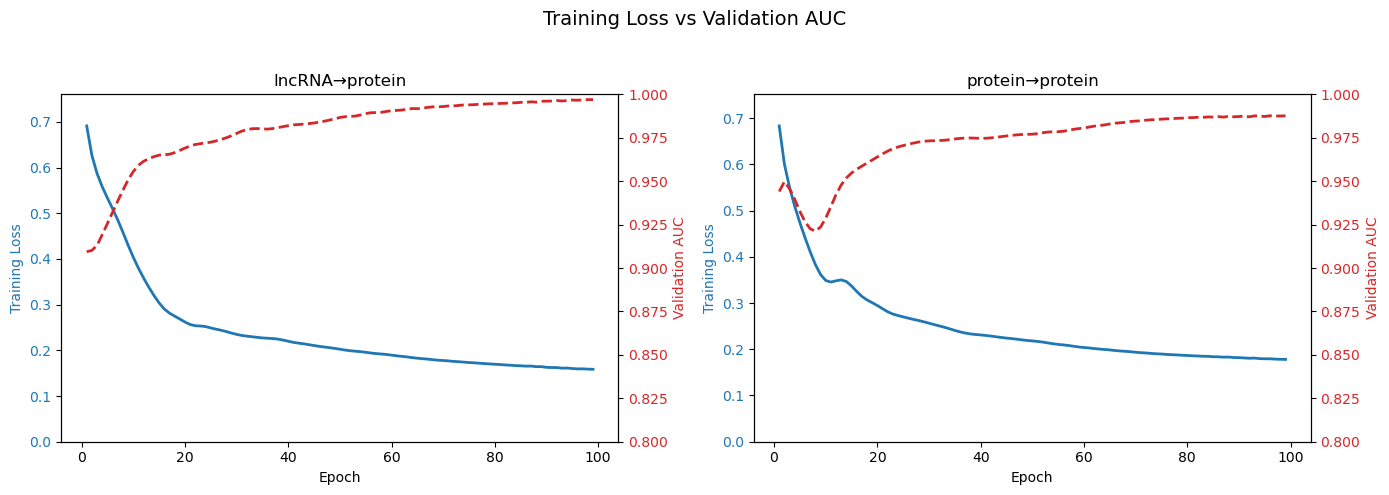

In [13]:
import matplotlib.pyplot as plt

edge_types_to_plot = [
    ('lncRNA', 'interacts', 'protein'),
    ('protein', 'interacts', 'protein'),
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)  

for i, edge_type in enumerate(edge_types_to_plot):
    train_loss = train_loss_log[edge_type]
    val_auc = val_auc_log[edge_type]
    epochs = list(range(1, len(train_loss) + 1))

    ax1 = axes[i] 
    ax2 = ax1.twinx()

    # -- Train Loss --
    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color1)
    ax1.plot(epochs, train_loss, color=color1, linewidth=2, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(0, max(train_loss) * 1.1)

    # -- Validation AUC --
    color2 = 'tab:red'
    ax2.set_ylabel('Validation AUC', color=color2)
    ax2.plot(epochs, val_auc, color=color2, linewidth=2, linestyle='--', label='Val AUC')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(0.8, 1.0)

    # add sub-title
    ax1.set_title(f"{edge_type[0]}→{edge_type[2]}")

# add main title
fig.suptitle("Training Loss vs Validation AUC", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])    
plt.show()
